In [1]:
import time
import os
import copy

import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
cudnn.benchmark = True
plt.ion()

# load data

In [3]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = "./dataset/train_images/"
source_dataset = datasets.ImageFolder(data_dir)

train_size = int(0.8 * len(source_dataset))
valid_size = len(source_dataset) - train_size

train_set, valid_set = torch.utils.data.random_split(source_dataset, [train_size, valid_size])

In [5]:
class MakeDataset(torch.utils.data.Dataset):
    
    def __init__(self, sub_dataset, transform=None):
        self.dataset = sub_dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [6]:
train_set = MakeDataset(train_set, transform=data_transforms["train"])
valid_set = MakeDataset(valid_set, transform=data_transforms["valid"])

In [7]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_dl = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)

In [8]:
train_size = len(train_set)
valid_size = len(valid_set)

train_size, valid_size

(8325, 2082)

In [9]:
class_names = source_dataset.classes
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# visualize few images

In [11]:
inputs, classes = next(iter(train_dl))
inputs.shape, classes

(torch.Size([16, 3, 224, 224]),
 tensor([6, 8, 0, 4, 3, 9, 0, 9, 9, 9, 1, 8, 2, 7, 3, 8]))

In [12]:
def supply_imgs(n=16):
    random_img_idxs = np.random.choice(train_set.dataset.indices, size=n)
    for idx in random_img_idxs:
        yield(source_dataset[idx])

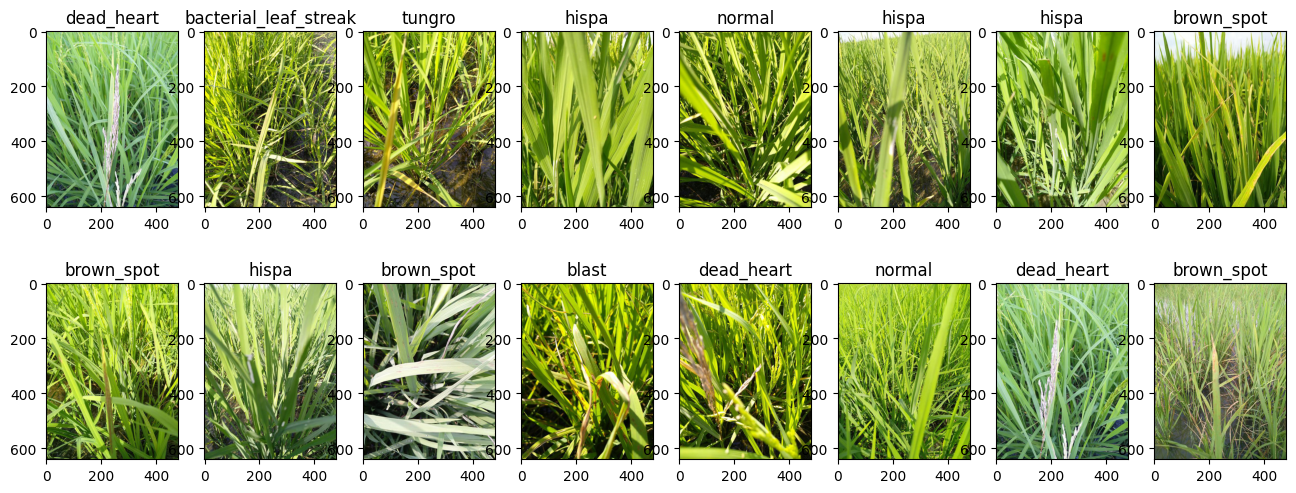

In [13]:
nrows = 2
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
supply_imgs_iter = supply_imgs()

for i in range(nrows):
    for j in range(ncols):
        img, label = next(supply_imgs_iter)
        ax[i][j].imshow(img)
        ax[i][j].set_title(train_set.dataset.dataset.classes[label])
plt.show()

# training the model

## define model

In [14]:
model = models.resnet18()
num_ftrs = model.fc.in_features

In [15]:
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

## define loss

In [16]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

## define optimizer

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

## define lr_scheduler

In [18]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
exp_lr_scheduler

## train model

In [19]:
num_epochs = 1

In [20]:
since = time.time()

# save best model weights and accuracy
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    print("-" * 10)
    
    for phase in ["train", "valid"]:
        
        if phase == "train":
            dataset_size = train_size
            dataloader = train_dl
        else:
            dataset_size = valid_size
            dataloader = valid_dl
        
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        
        for i, (inputs, labels) in tqdm(enumerate(dataloader), total=dataset_size/16):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # zero the parameter gradients
            
            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)
                
        if phase == "train":
            exp_lr_scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print(f"{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

        if phase == "valid" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60}s")
print(f"Best accuracy: {best_acc:.4f}")

model.load_state_dict(best_model_wts)

Epoch 0/0
----------


521it [00:18, 27.52it/s]                                                        

train Loss: 2.0411 Accuracy: 0.3151



131it [00:05, 24.84it/s]                                                        

valid Loss: 1.8515 Accuracy: 0.3742
Training complete in 0m 24.300638675689697s
Best accuracy: 0.3742


<All keys matched successfully>

# Predictions

In [22]:
test_set = datasets.ImageFolder("./dataset/test_images/")

In [23]:
test_set = MakeDataset(test_set, transform=data_transforms["valid"])
test_set

In [24]:
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)

In [27]:
model.to("cpu")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
subm_df = pd.DataFrame(columns=["image_id", "label"])
predictions = []
model.eval()
for inputs, labels in test_dl:
#     inputs = inputs.to(device)
    output = model(inputs)
    predictions += output
    
predictions = train_set.dataset.dataset.class_to_idx(predictions)
predictions[:5]

In [ ]:
torch.max(output, dim=1).indices